In [1]:
import warnings
warnings.filterwarnings('ignore')

import tensorflow as tf
import tensorflow_probability as tfp

tf.random.set_seed(42)

# Limit GPU memory usage
physical_devices = tf.config.experimental.list_physical_devices('GPU')
if len(physical_devices) > 0:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)

tfpl = tfp.layers
tfd = tfp.distributions

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler as Scaler

from sklearn.datasets import make_moons as make_class

print(f"TensorFlow version: {tf.__version__}")
print(f"TensorFlow Probatility version: {tfp.__version__}")

TensorFlow version: 2.8.0
TensorFlow Probatility version: 0.16.0


## Effect of KL-Weight on Toy Data

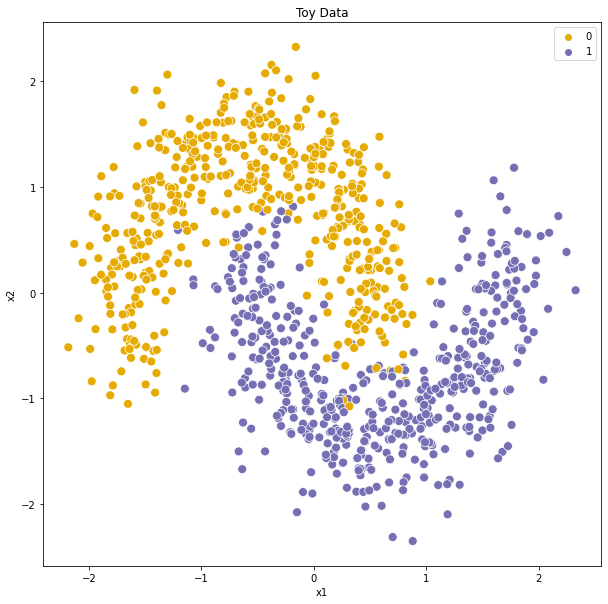

In [2]:
x, y = make_class(n_samples=1000, random_state=42, noise=0.2)
scaler = Scaler()
x = scaler.fit_transform(x)

y_ohe = tf.keras.utils.to_categorical(y)

# Plot the data
plt.figure(figsize=(10,10))
sns.scatterplot(x=x[:,0], y=x[:,1], hue=y, s=80,
                palette=sns.color_palette("Dark2_r", 2))

plt.xlabel('x1')
plt.ylabel('x2')

plt.title('Toy Data')
plt.show()

In [3]:
# Write a callback to record posterior standard deviations every epoch.
class PosteriorRecorder(tf.keras.callbacks.Callback):

    def __init__(self, **kwargs):
         super(PosteriorRecorder).__init__(**kwargs)
         self.stddevs = []
         self.dummy_input = tf.zeros((1, 2))

    def on_epoch_end(self, epoch, logs):
        posterior = self.model.layers[0]._posterior(self.dummy_input)
        self.stddevs.append(posterior.stddev().numpy())

In [4]:
def prior(kernel_size, bias_size, dtype = None):
    n = kernel_size + bias_size
    return tf.keras.Sequential([
        tfpl.DistributionLambda(lambda t: tfd.Independent(tfd.Normal(loc=tf.zeros(n),
                                                                     scale=tf.ones(n)),
                                                          reinterpreted_batch_ndims=1))
    ])

def posterior(kernel_size, bias_size, dtype = None):
    n = kernel_size + bias_size
    return tf.keras.Sequential([
        tfpl.VariableLayer(tfpl.MultivariateNormalTriL.params_size(n)),
        tfpl.MultivariateNormalTriL(n),
])

def nll(y_true, y_pred):
    return -y_pred.log_prob(y_true)

def train_model(kl_weight):
    model = tf.keras.Sequential([
                    tf.keras.layers.InputLayer(input_shape=(x.shape[1],)),
                    tfpl.DenseVariational(tfpl.OneHotCategorical.params_size(2),
                                          make_posterior_fn=posterior,
                                          make_prior_fn=prior,
                                          activation=None,
                                          kl_weight = kl_weight),
                    tfpl.OneHotCategorical(2, convert_to_tensor_fn=tfd.Distribution.sample)
    ])
    # model.summary()

    model.compile(
                 optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                 loss=nll,
                 metrics=['accuracy'])
    
    posterior_records = PosteriorRecorder()
    
    history = model.fit(x, y_ohe, epochs=125, batch_size=32, callbacks=[posterior_records],
                        verbose = 0)
    
    print(f"Loss:", history.history['loss'][-1], "\nAccuracy:", history.history['accuracy'][-1])
    return history, posterior_records

In [5]:
results = {}
for kl_weight in [0.0, 1/x.shape[0] * 0.1, 1/x.shape[0] * 0.5,  1/x.shape[0] * 3, 1/x.shape[0]]:
    print(f"Training model with KL-Weight = {kl_weight}")
    history, posterior_records = train_model(kl_weight)

    results[kl_weight] = {
        'history': history,
        'posterior_stddevs': np.array(posterior_records.stddevs),
    }
    print(f"Saving results for KL-Weight = {kl_weight}", "\n")

Training model with KL-Weight = 0.0
Loss: 0.29326504468917847 
Accuracy: 0.8169999718666077
Saving results for KL-Weight = 0.0 

Training model with KL-Weight = 0.0001
Loss: 0.2938649654388428 
Accuracy: 0.8159999847412109
Saving results for KL-Weight = 0.0001 

Training model with KL-Weight = 0.0005
Loss: 0.2962404489517212 
Accuracy: 0.8149999976158142
Saving results for KL-Weight = 0.0005 

Training model with KL-Weight = 0.003
Loss: 0.31027355790138245 
Accuracy: 0.8109999895095825
Saving results for KL-Weight = 0.003 

Training model with KL-Weight = 0.001
Loss: 0.29915672540664673 
Accuracy: 0.8130000233650208
Saving results for KL-Weight = 0.001 



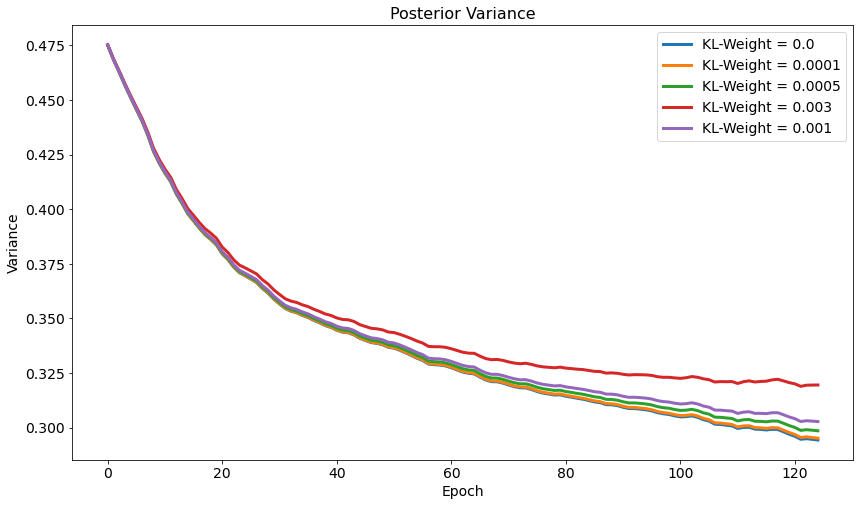

In [6]:
# Plot the posterior standard deviations
plt.figure(figsize=(14,8))
for kl_weight, result in results.items():
    var = result['posterior_stddevs'] ** 2
    plt.plot(var.mean(axis = 1), label=f"KL-Weight = {kl_weight}", linewidth = 3)
    plt.legend(fontsize=14)
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('Variance', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.title('Posterior Variance', fontsize=16)
plt.show()

In [ ]:
https://www.kaggle.com/datasets/pranavraikokte/covid19-image-dataset/code?datasetId=627146&sort=published